# Simulace šíření nákazy - zjednodušený 2D model

### Načítání balíčků
Budeme používat knihovnu **numpy** s aliasem **np** pro matematické funkce a práci s poli a knihovnu **matplotlib** s aliasem **plt** pro vykreslování výsledků. Pro pěknou vizualizaci průběhu simulace si také vyzkoušíme animace **FuncAnimation** z knihovny matplotlib. 

Následujícím kódem naimportujeme balíčky. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Pro interaktivní vykreslování grafů v Jupyter notebooku ještě potřebujeme toto:

In [2]:
%matplotlib notebook

### Principy simulace
Budeme simulovat časový vývoj šíření nemoci v populaci. Nejprve si nastavíme několik parametrů: **pocet_lidi**, **delka_simulace** v minutách a **cas_krok** v minutách. **pocet_lidi** a **delka_simulace** můžeme později pro účely testování libobolně měnit, **cas_krok** však budeme uvažovat jako konstatní, což výrazně zjednoduší naši práci.

In [3]:
pocet_lidi=1000 # nezadavejte hodnoty vetsi nez 5000, simulace pak bude velmi pomala
delka_simulace=30*24*60 # 30 dni * 24 hodin * 60 minut
cas_krok=15

Princip naší simulace bude následující:
- Jednotliví lidé budou reprezentováni body ve 2D
- Tyto body se budou v čase (jednotlivých časových krocích) pohybovat
- Pokud je někdo nakažen, může nakazit lidi ve své blízkosti

### SIR model
SIR model popisuje základní principy šíření nemoci. Je založen na rozdělení populace do ří skupin:
1. **S** (susceptible) - lidé, kteří doposud nepřišli do styku s nemocí a mohou se nakazit
2. **I** (infected) - nakažení jedinci, mohou nakazit lidi ze skupiny **S**
3. **R** (removed) - jedinci, kteří se už nemohou nakazit (ať už v dobrém - imunita, či zlém - smrt). Budeme uvažovat, že po pevně dané době se z **I** stává **R**


<hr style="border:1px solid black"> </hr>

## Úkol 1: 
vygenerujte pro každého náhodnou pozici z [0,1]x[0,1] a vykreslete

<hr style="border:1px solid black"> </hr>

<IPython.core.display.Javascript object>


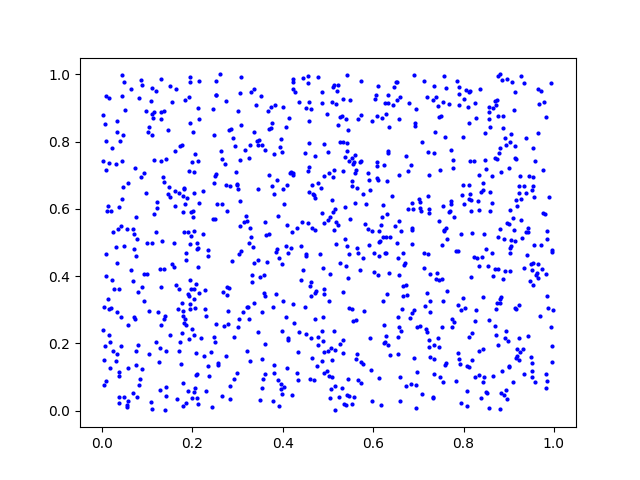

In [4]:
pozice = np.random.rand(pocet_lidi,2)
plt.figure()
plt.plot(pozice[:,0],pozice[:,1],"bo",markersize=2)

Dále vyrobíme numpy pole, které bude identifikovat jednotlivé skupiny **S, I, R**. Ze začátku budeme považovat všechny ve stavu **S**.

In [5]:
stav = np.full(pocet_lidi,'S')

V dalších částech budeme chtít vybírat z polí parametrů (například pozice) pouze hodnoty příslušné ke konkrétní skupině (S, I, R). To se dá jednoduše takto:

In [6]:
pozice_S = pozice[stav == 'S',:]

<hr style="border:1px solid black"> </hr>

## Úkol 2: 
převeďte lidi 0-99 z S do I a lidi 100-299 z S do R, vykreslete (S-modrá="bo", I-červená="ro", R-zelená="go")

<hr style="border:1px solid black"> </hr>

<IPython.core.display.Javascript object>


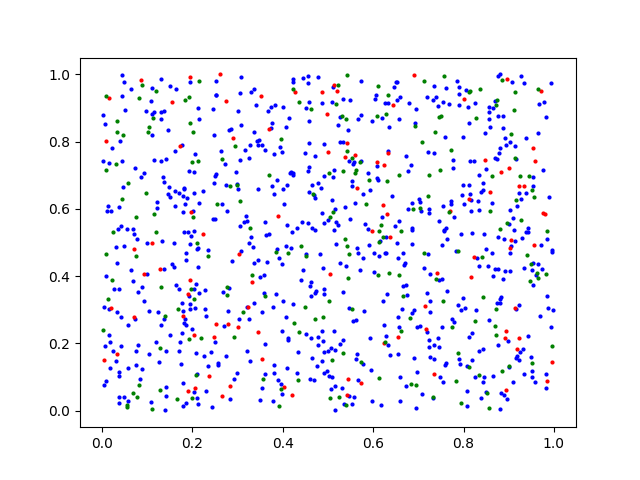

In [7]:
# zmente stavy
stav[0:99]='I'
stav[100:299]='R'
# vykreslete
plt.figure()
# tri ploty, kazdy pro jednu barvu
plt.plot(pozice[stav == 'S',0],pozice[stav == 'S',1],"bo",markersize=2)
plt.plot(pozice[stav == 'I',0],pozice[stav == 'I',1],"ro",markersize=2)
plt.plot(pozice[stav == 'R',0],pozice[stav == 'R',1],"go",markersize=2)

### Vykreslování průběžných výsledků - Animace
Abychom se mohli dostat dále, ukážeme si, jak se dělají animace. Budeme používat funkci **FuncAnimation**, která pracuje následovně:
- má 3 základní parametry:
 - objekt figure z matplotlib (**fig**)
 - námi vytvořená funkce, říkejme jí **update**
 - iterovatelé pole (**frmes**), případně počet framů (pokud je vstupem iterovatelné pole, pak je počet framů velikost tohoto pole)
- pro nás nejdůležitější bude funkce **update**, projděme si tedy její vlastnosti:
 - jako vstup bude dostávat jednotlivé položky vstupu **frames**
 - zavolá se jednou pro každou položku **frames**, bude tedy obsahovat celou naši simulaci jednoho časového kroku
 - bude obsahovat aktualizace součástí grafů které budeme chtít mezi jednotlivými framy měnit

Abyste si udělali lepší představu, ukážeme demostraci:

Nejprve vyrobení grafu, do kterého budeme vykreslovat animaci. Pro jednoduché znovupoužití bez kopírování si na to napíšeme funkci.

**Neděste se množství kódu, je ho mnoho, protože si nastavíme dvě okna:**
- **levé okno bude obsahovat aktuální dění v simulaci - pohyb teček a jejich barevné určení**
- **do pravého okna budeme vykreslovat časový vývoj simulace v podobě počtu lidí v jednotlivých skupinách**
 - modrá = S
 - červená = I
 - zelená = R
 - pro pozdější využití zavedeme také karanténu = černá = Q
 
 **Není nutné rozumět veškerému kódu níže.** 

In [8]:
def nova_animace():
    #jednoduchý způsob jak najednou vyrobit figure včetně os
    figure_animace, axs = plt.subplots(ncols=2,figsize=(9.5,4)) # vyrobíme dvoje osy - simulace/časový vývoj
    # zobrazení simolace (tečky repr. lidi)
    ln1, = axs[0].plot(pozice[stav == 'S',0],pozice[stav == 'S',1],"bo",markersize=2) #graf do konkrétních os (axs)
    ln2, = axs[0].plot(pozice[stav == 'I',0],pozice[stav == 'I',1],"ro",markersize=2)
    ln3, = axs[0].plot(pozice[stav == 'R',0],pozice[stav == 'R',1],"go",markersize=2)
    ln4, = axs[0].plot(pozice[stav == 'Q',0],pozice[stav == 'Q',1],"ko",markersize=2)

    #text v pravo dolů relativně vůči osám, typ textu monospaced
    title = axs[0].text(1,0, "text",transform=axs[0].transAxes, ha="right", va="bottom", fontfamily='monospace') 

    axs[0].set_xlim(-0.5, 1.5) # rozmesí osy X
    axs[0].set_ylim(-0.5, 1.5) # rozmesí osy Y
    
    akt_nakazenych = (stav == 'I').sum()
    akt_nakazitelnych = (stav == 'S').sum()
    akt_odstranenych = (stav == 'R').sum()
    akt_v_karantene = (stav == 'Q').sum()
    
    # zobrazení časového vývoje - grafy poču lidí v jednotlivých skupinách
    ln5, = axs[1].plot(0, akt_v_karantene,"k-")
    ln6, = axs[1].plot(0, akt_odstranenych,"g-")
    ln7, = axs[1].plot(0, akt_nakazitelnych,"b-")
    ln8, = axs[1].plot(0, akt_nakazenych,"r-") 
    
    axs[1].set_xlim(0, delka_simulace) # rozmesí osy X
    axs[1].set_ylim(-pocet_lidi*0.01, pocet_lidi*1.01) # rozmesí osy Y
    
    return figure_animace, (ln1, ln2, ln3, ln4, ln5, ln6, ln7, ln8, title) # musíme vrátit, aby byly dostupné v gl.

Zavoláním **nova_animace** dostaneme graf, nezapomeňte, že všechny komponenty grafu muzí být na výstupu, jinak se nedostanou do kontextu mimo funkci a my je pak nebudeme moci dále použít/upravit:

<IPython.core.display.Javascript object>


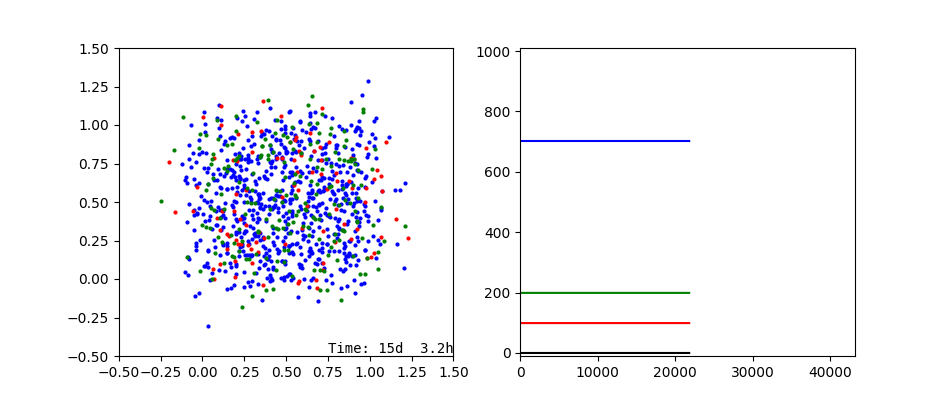

In [9]:
figure_animace, komponenty_grafu = nova_animace()

Dále vyrobíme zmíněnou funkci **update**, pro jednodušší použití v dalších úkolech si vyrobíme zvlášť funkci, která bude obstarávat vykreslování (jak barevných teček, tak času simulace) **vykresleni**.

Funkce vykreslení bude upravovat data komponent grafu (jednotlivé čáry, případně text) dle současného stavu simulace.

**Opět, není nutné detailní porozumění tohoto kódů, neděste se délky (dlouhý je především kvůli počtu komponent).**

In [10]:
def vykresleni(cas_simulace_minuty):
    ln1 = komponenty_grafu[0] # rozbalíme si všechny komponenty z výsledného touple 
    ln2 = komponenty_grafu[1] # toto děláme především kvůli přehlednosti následujícího kódu
    ln3 = komponenty_grafu[2] # pzn. ln1,... jsou pouze ukazatele na objekty, změny v nich změní původní data
    ln4 = komponenty_grafu[3]
    ln5 = komponenty_grafu[4]
    ln6 = komponenty_grafu[5]
    ln7 = komponenty_grafu[6]
    ln8 = komponenty_grafu[7]
    title = komponenty_grafu[8]
    
    cas_simulace_hodiny = np.mod(cas_simulace_minuty/60,24) #napočítáme aktuální čas
    cas_simulace_dny = cas_simulace_minuty/24/60
    
    akt_nakazenych = (stav == 'I').sum()
    akt_nakazitelnych = (stav == 'S').sum()
    akt_odstranenych = (stav == 'R').sum()
    akt_v_karantene = (stav == 'Q').sum()
    
    # nyní aktualizujeme data objektů (čáry/body v grafu a text) - změny souřadnic a textu
    ln1.set_xdata(pozice[stav == 'S',0]) # nastavíme nové souřadnice x
    ln1.set_ydata(pozice[stav == 'S',1]) # nastavíme nové souřadnice y
    ln2.set_xdata(pozice[stav == 'I',0])
    ln2.set_ydata(pozice[stav == 'I',1])
    ln3.set_xdata(pozice[stav == 'R',0])
    ln3.set_ydata(pozice[stav == 'R',1])
    ln4.set_xdata(pozice[stav == 'Q',0])
    ln4.set_ydata(pozice[stav == 'Q',1])
    # pro zápis aktuálního času provedeme následující, funkce format dá na místo {:2.0f} a {:4.1f} čísla v param.
    title.set_text("Time: {:2.0f}d {:4.1f}h".format(cas_simulace_dny,cas_simulace_hodiny)) #nastavíme nový text
    # u druhého grafu použijeme předchozí data jako paměť, proto pokaždé akorát přilepíme (append) novou hodnotu
    ln5.set_xdata(np.append(ln5.get_xdata(), cas_simulace_minuty)) # nastavíme nové souřadnice x
    ln5.set_ydata(np.append(ln5.get_ydata(), akt_v_karantene)) # nast. s. y   
    ln6.set_xdata(np.append(ln6.get_xdata(), cas_simulace_minuty))
    ln6.set_ydata(np.append(ln6.get_ydata(), akt_odstranenych))
    ln7.set_xdata(np.append(ln7.get_xdata(), cas_simulace_minuty))
    ln7.set_ydata(np.append(ln7.get_ydata(), akt_nakazitelnych))    
    ln8.set_xdata(np.append(ln8.get_xdata(), cas_simulace_minuty)) 
    ln8.set_ydata(np.append(ln8.get_ydata(), akt_nakazenych))
    return # nemusíme nic vracet, všechno jsou objeky v globální paměti, tedy změny zůstanou zachovány

Konečně přistoupíme k funkci **update**, ta bude díky předchozí funkci velmi jednoduchá a přímočará:

In [11]:
def update(cas_simulace_minuty): #na vstupu budeme uvažovat aktuální čas
    # upravíme pozice, ať vidíme že se něco děje 
    #(pozor na: pozice =... v tu chvíli bychom definovali novou lokální proměnnou, += pouze upraví obsah pozic)
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #přičteme k nim náhodné číslo mezi -0.005 s 0.005
    
    vykresleni(cas_simulace_minuty) # zavolání vykreslovací funkce (až potom co upravíme pozice,S,I,R,...)
    return  # musíme vrátit všechny komponenty grafu, které chceme překreslit

Zbývá už jen spustit animaci funkcí **FuncAnimation**, první parmetr je figure, ve kterém se bude vše dít, pak updatovací funkce zajišťující samotnou animaci, dále proměnná frames obsahující sekvenci všech časů, ve kterých bude funkce update spuštěna. Dodatečných parametrů si nemusíte všímat, pokud by vás však zajímalo, co dělají pak:
- blit - jestli chceme překreslit vše, nebo jen co se změnilo, 
- interval - pauza mezi framy v milisekundách a 
- repeat - zda chceme opakovat pořád dokola.

**Pozor animace poběží v okně nahoře, tam kde se prvně vykreslila při inicializaci. Simulaci můžete kdykoliv ukončit vypínacím tlačítkem vpravo nahoře.**

In [12]:
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1, repeat = False)
plt.show()

#### Nezapomeňte, že veškeré proměnné z dřívějších inputů jsou stále aktivní - restart/reinicializace vstupních dat
Jelikož si nyní začneme hrát se simulací, bude se nám hodit funkce, která vyresetuje všechny parametry simulace. Jako základní stav budeme uvažovat všechny lidi ve stavu **S** kromě prvních 5 (index 0 - 4), kteří budou ve stavu **I**.

Abychom tuto funkci nemuseli později přepisovat, rovnou přidáme další pole, která později využijeme při rozšiřování naší simulace.

In [13]:
def reset_simulace():
    pozice = np.random.rand(pocet_lidi,2)
    doba_od_nakazeni = np.zeros((pocet_lidi))
    stav = np.full(pocet_lidi,'S')
    stav[0:4] = 'I'
    return pozice, stav, doba_od_nakazeni

Budeme jí pak volat takto:

In [14]:
pozice, stav, doba_od_nakazeni = reset_simulace()

Můžeme si zkontrolovat výsledek pomocí spuštění nové animace:

<IPython.core.display.Javascript object>


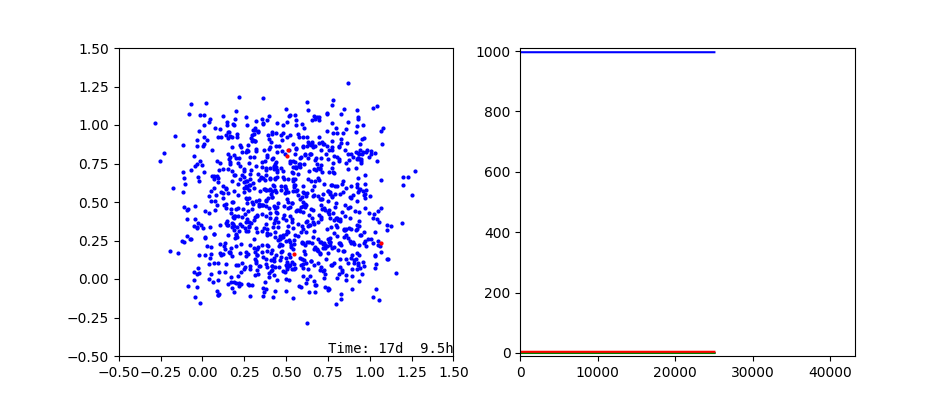

In [15]:
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), 
                    blit=True,interval=1,repeat=False)
plt.show()

### Implementace nákazy
Abychom mohli pokročit dál, budeme muset naprogramovat průběh nákazy. Jedním z důležitých faktorů je vzdálenost mezi nakaženým **I** a nakazitelným **S** jedincem.

Abychom so toto mohli lépe ozkoušet, nastavíme nákazu dalším 5 lidem a ukážeme si, jak jednoduše dostat pole indexů s konkrétními stavy.

In [16]:
stav[7] = 'I'
stav[12] = 'I'
stav[15] = 'I'
stav[6] = 'I'
stav[3] = 'I'
idx_I, = (stav == 'I').nonzero()
print(idx_I)

[ 0  1  2  3  6  7 12 15]


Je tam také index 0, protože jsme ho měli už v inicializaci.

Řekněme, že lidé se mohou nakazit, pokud jsou ve vzdálenosti menší než 0.02 od infikovaného.

In [17]:
vzdalenost_nakazy = 0.02
mohl_se_nakazit = np.full(pocet_lidi,False)

<hr style="border:1px solid black"> </hr>

## Úkol 3: 
spočtěte vzdálenosti mezi nakaženými **I** a nakazitelnými **S**, pokud má nakazitelný **S** vzdálenost do některého nakaženého menší než **vzdalenost_nakazy**, pak vepište do příslušné pozice v poli **mohl_se_nakazit** hodnotu True

<hr style="border:1px solid black"> </hr>

In [18]:
# indexy lidi ve stavu S a stavu I
idx_I, = (stav == 'I').nonzero()
idx_S, = (stav == 'S').nonzero()
# dvě vnořené smyčky ať projdeme všechny dvojice
for i in idx_I:
    for j in idx_S:
        rozdil =pozice[i,:]-pozice[j,:]
        distance = np.sqrt(rozdil[0]**2 + rozdil[1]**2)
        if distance <= vzdalenost_nakazy:
            mohl_se_nakazit[j] = True

Pro kontrolu si vykresleme nakažené jedince a ty z **S**, kteří se nakazit mohli:

<IPython.core.display.Javascript object>


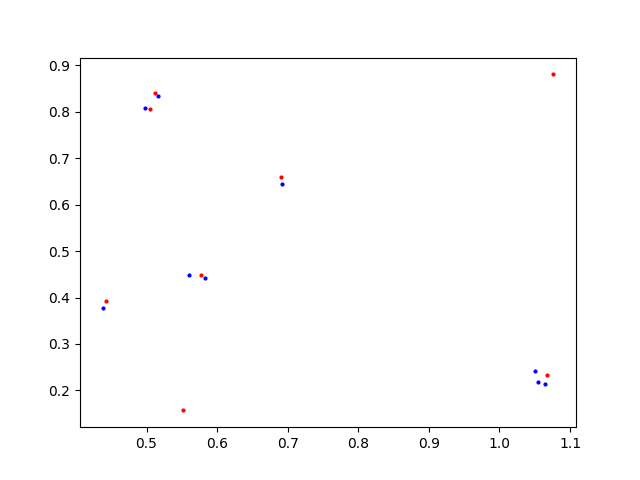

In [19]:
plt.figure()
plt.plot(pozice[(stav == 'S') & mohl_se_nakazit,0],pozice[(stav == 'S') & mohl_se_nakazit,1],"bo",markersize=2)
plt.plot(pozice[stav == 'I',0],pozice[stav == 'I',1],"ro",markersize=2)

Doufám, že se vše zdařilo, pokud ne, podívejte se do řešení, bez této části se totiž dále nedostaneme.

#### Pravděpodobnost nakažení při kontaktu s nakaženým
Jelikož né vždy, když se dostanete do blízkosti nakaženého, se hned nakazíte, budeme chtít toto zanést i do našeho modelu. Jelikož budeme pracovat s 15 minutovými časovými kroky, můžeme pracovat s pravděpodobností nákazy 5 %. 

To znamená, že pokud se po dobu 15 minut (náš časový krok) pohybujete v blízkosti nakaženého, je 5 % šance, že se nakazíte. **5 % od každého nakaženého**, asi souhasite s tím, že při pohybu mezi 10 nakaženými je šance nákazy výrazně větší, než při pohybu v blízkost jednoho nakaženého. (nikoliv však 10x větší - můžete si rozmyslet) 

In [20]:
pravdepodobnost_nakazy = 0.05
np.random.rand() < pravdepodobnost_nakazy # takto vyrobíme náhodný pokus, kde s pravděpodobností 5 % výjde True

True

<hr style="border:1px solid black"> </hr>

## Úkol 4: 
implementujte funkci **nove_nakazeni**, ve které je pro každého ze skupiny **S** v kontaktu s každým nakaženým **I** aplikována šance na nákazu **pravdepodobnost_nakazy**. Výstupem bude pole nově nakažených.
- pro každou dvojici S-I spočítáte vzdálenost
- pokud je vzdálenost kratší, než **vzdalenost_nakazy**, aplikujete **pravdepodobnost_nakazy** -> True hodnota znamená že se jedinec S nakazil

<hr style="border:1px solid black"> </hr>

In [21]:
def nove_nakazeni():
    # nainicializujte si pole nakazili_se na hodnoty False (do nějk pak přidáme True pokud se někdo nakazí)
    nakazili_se = np.full(pocet_lidi,False)
    # indexy jednotlivých I a S
    idx_I, = (stav == 'I').nonzero()
    idx_S, = (stav == 'S').nonzero()
    # smyčka přes všechny dvojice
    for i in idx_I:
        for j in idx_S:
            rozdil =pozice[i,:]-pozice[j,:]
            distance = np.sqrt(rozdil[0]**2 + rozdil[1]**2)
            if distance <= vzdalenost_nakazy:
                if np.random.rand() < pravdepodobnost_nakazy:
                    nakazili_se[j] = True
    return nakazili_se

Nyní můžeme upravit funkci **update**, tak aby používala nově vyrobenou funkci:

In [22]:
def update(cas_simulace_minuty):
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #totéž co v předchozí funkci
    
    nakazili_se = nove_nakazeni() # naše nový funkce
    
    stav[nakazili_se] = 'I' # změna stavu dle nových nákaz
   
    vykresleni(cas_simulace_minuty) 
    return

Samotná animace bohužel neukáže, pokud má funkce **update** nebo její součást nějakou chybu, proto je lepší vyzoušet ji samostatně (pokud se nic nestane, znamená, to že jsme neudělali chybu v syntaxi a funce proběhla bez pádu).

In [23]:
update(0) # nebo update(1000) pro pozdější časový krok

A spustíme simulaci, ať vidíme, co se nám povedlo:

<IPython.core.display.Javascript object>


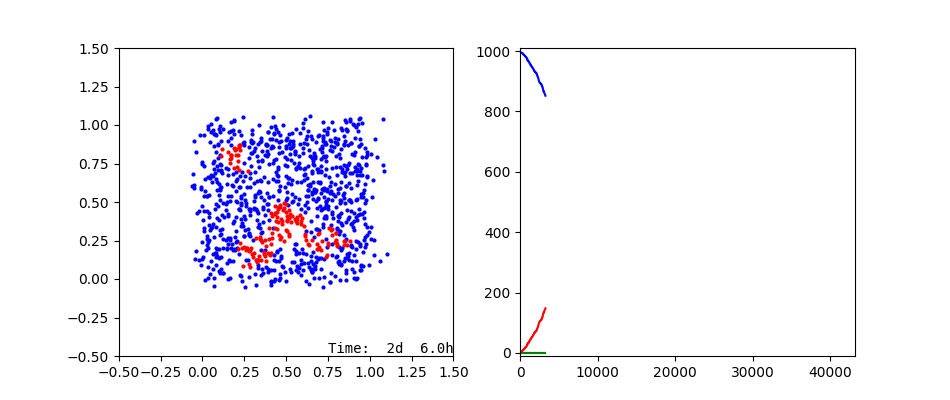

In [24]:
pozice, stav, doba_od_nakazeni = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1,repeat=False)
plt.show()

Gratuluji, pokud vám to běží. Nicméně jste si pravděpodobně všimli, že je to nyní velice pomalé. Je to tím, že i takto jednoduchá simulace vyžaduje mnoho výpočtů, které navíc nyní děláme velice neefektivně. **Simulaci můžete vypnout tlačítkem v pravo nahoře animovaného okna.**

#### Efektivní implementace
Výpočty se dají dělat mnohem efektivněji, vyzkoušete simulaci s tímto kódem:

In [1]:
def nove_nakazeni():
    pI1 = pozice[stav == 'I',0]; pI2 = pozice[stav == 'I',1]; # vybereme si x a y pozice všech nakažených
    pS1 = pozice[stav == 'S',0]; pS2 = pozice[stav == 'S',1]; # vybereme si x a y pozice všech nakazitelných
    pS1 = pS1[None]; pS2 = pS2[None]; # původní pole pS1 a pS2 byly 1d a my budeme potřeboat jejich transpozici
    pS1 = pS1.T; pS2 = pS2.T; # zde je traspozice, nyní jsme ji mohli udělat (předchozí řádek jim přidal dimenzi)
    r1=pS1-pI1 #rozdíl v x souřadnicích (všiněme si, že je to sloupec - řádek, python je chytrý tak vyrobí matici)
    r2=pS2-pI2 #rozdíl v y souřadnicích -- takovéto práci s vektory se říká broadcasting 
    mohli_se_nakazit = (r1*r1+r2*r2) < vzdalenost_nakazy**2 #vyhneme se počítání odmocniny, tak že porovnáme s x^2
    mn = mohli_se_nakazit.shape #velikost výsledné matice
    nakazili_se_loc = np.random.rand(mn[0],mn[1]) < pravdepodobnost_nakazy #šance, že se nakazili, ale pro všechny
    nakazili_se_loc = nakazili_se_loc and mohli_se_nakazit #nakažení jsou ti kteří měli True na šanci a byli blízko
 
    nakazili_se = np.full(pocet_lidi,False) #alokace výsledného pole
    nakazili_se[stav == 'S'] = nakazili_se_loc.sum(1) > 0 #zapsání napočtených výsledků 
                                                      #(suma přes všechny kontkakty s nemocnými)
    return nakazili_se

Nelamte si hlavu s tím, co tento kód přesně dělá. Jeho podrobné pochopení je nad rámec tohoto kurzu.

Raději ho vyzkoušejte:

<IPython.core.display.Javascript object>


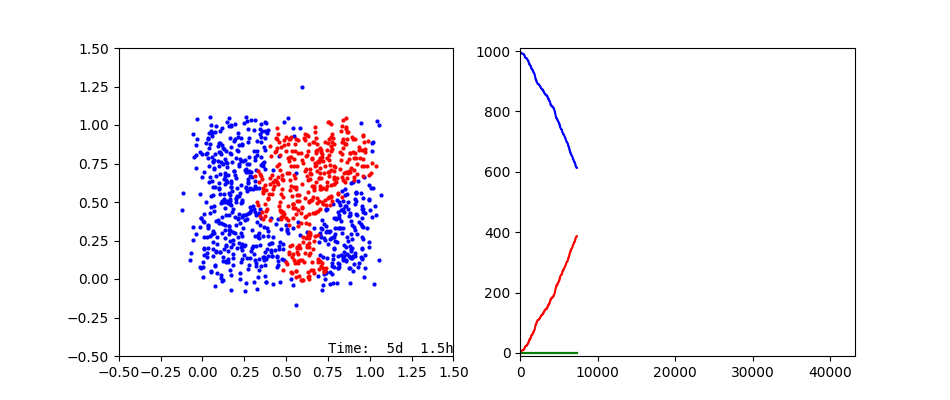

In [26]:
pozice, stav, doba_od_nakazeni = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1,repeat=False)
plt.show()

Vidíme, že se naše nákaza velmi rychle šíří. Chybí nám však mechanizmus, který převede infekční jedince na jedince bez nákazy a zároveň jedince dále nenakazitelné.

### Zbavení se nákazy / přechod do stavu R

To vyřešíme pomocí počítadla doby nákazy:

In [27]:
delka_nakazy = 7*24*15
doba_od_nakazeni = np.zeros((pocet_lidi))

<hr style="border:1px solid black"> </hr>

## Úkol 5: 
přidejte do funkce update načítání času pro nakažené, dále v každém kroce kotrolujte, jestli čas nepřekročil délku nákazy, pokud ano, přesuňte jedince z I do R

<hr style="border:1px solid black"> </hr>

In [28]:
def update(cas_simulace_minuty):
    #totéž co v předchozí funkci
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 
    nakazili_se = nove_nakazeni() 
    stav[nakazili_se] = 'I' 
    
    #----------------------------------------------------------------------------------------
    # inkrementujte dobu_od_nakazeni pro lidi se stavem 'I'
    doba_od_nakazeni[stav == 'I'] +=15
    # ti, kteří překonají delka_nakazy se změní na stav 'R'
    po_nemoci = doba_od_nakazeni >= delka_nakazy   
    stav[po_nemoci] = 'R'
    #----------------------------------------------------------------------------------------
    
    vykresleni(cas_simulace_minuty) 
    return

Vyzkoušíme nově vytvořenou funkci: (vyzkoušejte si to spustit více krát, vzhledem k náhodnému generování výsledků to bude mít pokaždé jiný průběh)

<IPython.core.display.Javascript object>


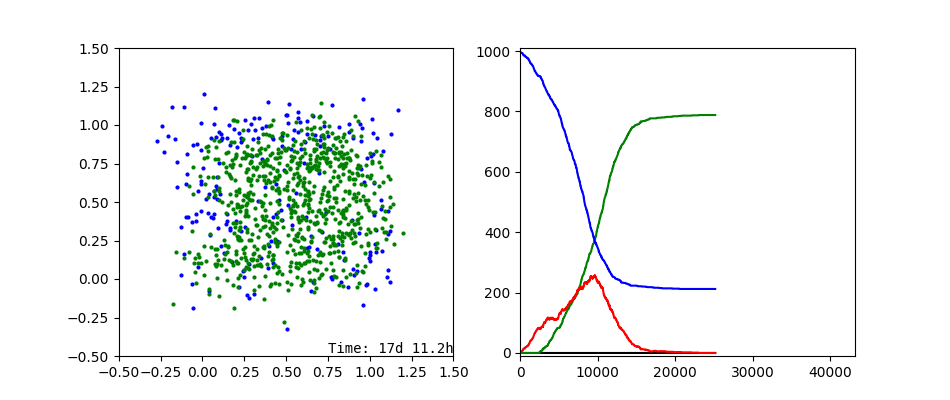

In [29]:
pozice, stav, doba_od_nakazeni = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1, repeat=False)
plt.show()

### Vyzkoušejte si různé parametry simulace
Pokud vše běží, můžete si zkusit 'pohrát' s parametry simulace. Zkuste například zvýšit pravěpobnost nákazy.

**Pokud bychom chtěli nějak napodobovat opatření, která teď zažíváme, tak můžeme uvažovat například následující:**
- **Nošení roušek/zvýšená hygiena sníží pravděpodobnost nákazy.**
- **Snaha o vyhýbání se ostatním lidem / limitování osobních kontaktů může malinko zmenšit vzdalenost, na kterou se tečky mohou nakazit.**


<IPython.core.display.Javascript object>


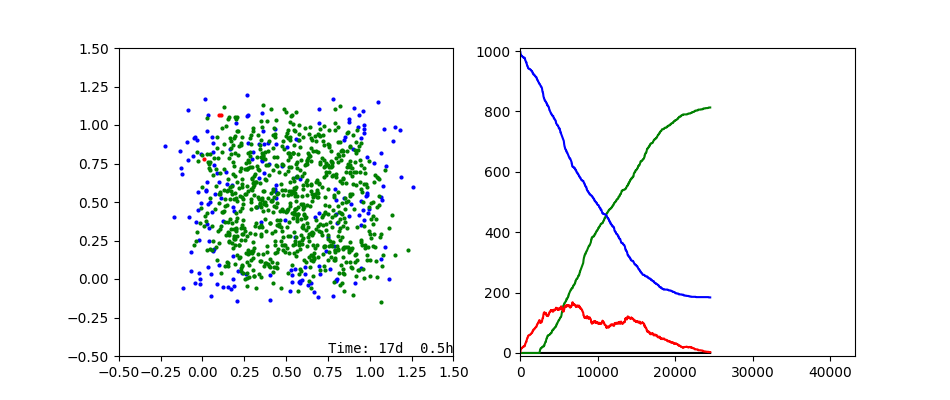

In [30]:
pocet_lidi=1000 #nezadavejte hodnoty vetsi nez 5000, simulace pak bude velmi pomala
delka_simulace=30*24*60 #30 dni * 24 hodin * 60 minut
vzdalenost_nakazy = 0.02 #vzdalenost na kterou se mužeme nakazit
pravdepodobnost_nakazy = 0.05 #pravděpodobnost, že se nakazíme
delka_nakazy = 7*24*15 #délka nákazy

pozice, stav, doba_od_nakazeni = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1, repeat=False)
plt.show()

### Více realistické tečky - pohyb mezi místy

Asi budete souhlasit s tím, že náhodně kmitající tečky nejsou dobrou aproximací pohybu lidí. Nyní zkusíme naši simulaci v tomto ohledu vylepšit. Budeme předpokládat, že každá tečka má nějaký domov a nějaké pracoviště. Podstatou tohoto je vynutit více náhodných kontaktů mezi tečkami se stejným domovem, případně stejným pracovištěm.

Nejprve si vyrobíme lokace domovů a pracovišť pro naše tečky:

In [31]:
grid_domovu = (4, 10) # velikost gridu domacnosti
grid_praci = (2, 5) # velikost gridu praci

prace_x_grid = np.linspace(1, 1.25, grid_praci[0]) # souřadnice v gridu prací na ose x
prace_y_grid = np.linspace(-0.25, 1.25, grid_praci[1]) # souřadnice v gridu prací na ose y
prace_x, prace_y = np.meshgrid(prace_x_grid, prace_y_grid) # vytvoření souřadnic (každý s každým x vs y)
prace = np.array([prace_x.flatten(), prace_y.flatten()]) # uspořádání souřadnic do formátu dvojic
prace = prace.T # ať mají stejné formát jako pozice - 2 sloupce x a y souřadnic

domovy_x_grid = np.linspace(-0.25, 0.25, grid_domovu[0]) # souřadnice v gridu domovů na ose x
domovy_y_grid = np.linspace(-0.25, 1.25, grid_domovu[1]) # souřadnice v gridu domovů na ose y
domovy_x, domovy_y = np.meshgrid(domovy_x_grid, domovy_y_grid) # vytvoření souřadnic (každý s každým x vs y)
domovy = np.array([domovy_x.flatten(), domovy_y.flatten()]) # uspořádání souřadnic do formátu dvojic
domovy = domovy.T # ať mají stejné formát jako pozice - 2 sloupce x a y souřadnic

Pro lepší představu si pozice domovů a pracovišť vykreslíme:

<IPython.core.display.Javascript object>


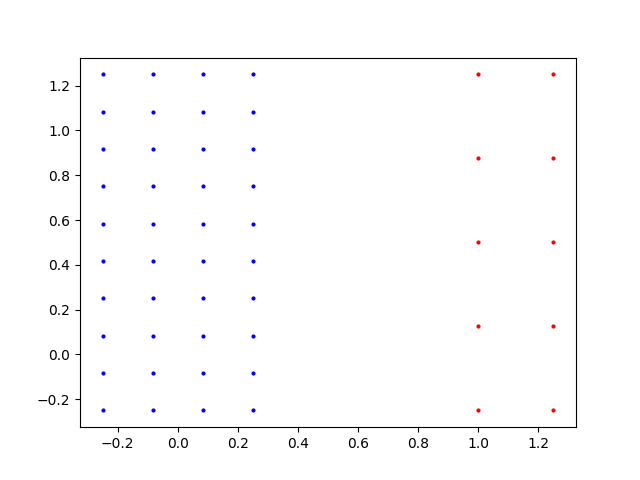

In [32]:
plt.figure()
plt.plot(domovy[:,0],domovy[:,1],"bo",markersize=2)
plt.plot(prace[:,0],prace[:,1],"ro",markersize=2)

Dále budeme chtít vyrobit dvě pole obdobné poli aktuálních pozic, které budou obsahovat pozice domovů a práce každého člověka/tečky.

Pro jednoduché znovuvyužití toto přidáme do funkce **reset_simulace**.
Použijeme funkci **random.randint** pro náhodné přiřazení pracoviště a domova pro každého:

In [33]:
def reset_simulace():
    pozice = np.random.rand(pocet_lidi,2) 
    doba_od_nakazeni = np.zeros((pocet_lidi))
    stav = np.full(pocet_lidi,'S')
    stav[0:4] = 'I'
    
    # np.random.randint má tři parametry - nejnižší číslo, nejvyšší číslo, počet hodnot
    domovy_lidi = domovy[np.random.randint(0, grid_domovu[0]*grid_domovu[1], pocet_lidi),:]
    prace_lidi = prace[np.random.randint(0, grid_praci[0]*grid_praci[1], pocet_lidi), :]
    
    return pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi

Nově budeme reset simulace volat takto (přibyly nám dvě nové výstupní hodnoty):

In [34]:
pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi = reset_simulace()

<hr style="border:1px solid black"> </hr>

## Úkol 6: 
Naimplementujte funkci **do_prace_a_zpet**, které bude splňovat následující:
- v čase od 6:00 do 14:00 se tečky přesouvají/jsou v práci
- ve zbytku času se tečky přesouvají/jsou doma
- rychlost přesunu teček je 0.1 v jednom časovém kroku
- funkce vrací vektor posunu (změny pozice) teček
- pokud jsou tečky do vzdálenosti 0.2 od pracoviště, už se nemusí dále přesouvat
- pokud josu tečky do vzdálenosti 0.05 od domova, už se nemusí dále přesouvat

<hr style="border:1px solid black"> </hr>

In [35]:
def do_prace_a_zpet(cas_simulace_minuty):
    # nezapomeňte, že cas_simulace_minuty je celkový čas. Jak zněj dostaneme čas od půlnoci dnes?
    cas_pres_den = np.mod(cas_simulace_minuty,24*60)
    # nastavte si promennou cil podle toho jaká část dne je
    if (cas_pres_den >= 6*60) & (cas_pres_den <= 14*60):
        cil = prace_lidi
    else:
        cil = domovy_lidi
    # najděte směr k cíli
    smer = cil - pozice
    # napočítejte si vzdálenost k cíli
    vzdalenost = np.sqrt(smer[:,0]**2 + smer[:,1]**2)
    # nezapomeňtě, že směr by měl být jednotkový vektor
    smer[:,0] /= vzdalenost
    smer[:,1] /= vzdalenost
    posun_velikost = vzdalenost.copy()  
    # napočítejte velikost o kterou se ve směru k cíli posunete (maximálně 0.1 což je rychlost)
    # může být 0, pokud jsme dostatečne blízko (v závislosti na cíli - času dne)
    posun_velikost[vzdalenost>0.1] = 0.1
    if (cas_pres_den >= 6*60) & (cas_pres_den <= 14*60):
        posun_velikost[vzdalenost<0.2] = 0
    else:
        posun_velikost[vzdalenost<0.075] = 0     
    # z jednotkového vektoru směru k cíli a velikosti posunu spočtěte celkový posun    
    posun = np.zeros((pocet_lidi,2))
    posun[:,0] += posun_velikost*smer[:,0]
    posun[:,1] += posun_velikost*smer[:,1]
    return posun

Funkce **update** bude pak vypadat následovně:

In [36]:
def update(cas_simulace_minuty):
    # volání nové funkce a posun pozic
    posun = do_prace_a_zpet(cas_simulace_minuty)
    pozice[:,:] += posun
    
    # zbytek stejně jako v předchozích funkcích
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #aby tečky nebyly zafixovány na jednom místě
    nakazili_se = nove_nakazeni() 
    stav[nakazili_se] = 'I' 
    doba_od_nakazeni[stav == 'I'] +=15
    po_nemoci = doba_od_nakazeni >= delka_nakazy
    stav[po_nemoci] = 'R'
     
    vykresleni(cas_simulace_minuty) 
    return

In [37]:
update(0)

Vyzkoušejte, jak vám to funguje:

<IPython.core.display.Javascript object>


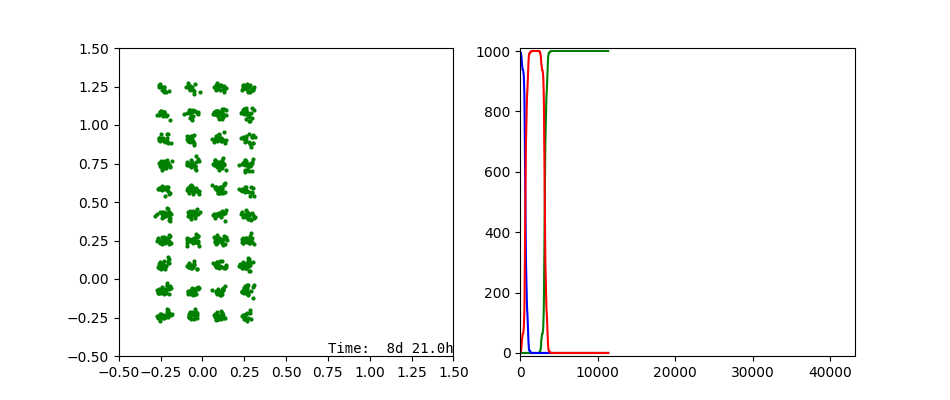

In [38]:
pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1, repeat=False)
plt.show()

### Karanténa

Jak vidíte, tak model, ve kterém se lidi častěji dostávají do kontaktu, způsobí extrémní rychlost šíření nákazy. Jedním ze způsobů, jak s tím můžeme bojovat, je určení nakažených jedinců (např. testem) a jejich uzavření do karantény.

Proto zavedeme novou proměnnou našeho modelu **pravdepodobnost_zjisteni_a_karanteny**, která bude určovat pravděpodobnost, že po nakažení se daná tečka dostane do karantény = nemůže nikoho dalšího nakazit.

In [39]:
pravdepodobnost_zjisteni_a_karanteny = 0.75

<hr style="border:1px solid black"> </hr>

## Úkol 7: 
Upravte funkci **update** tak, aby nově nakažené tečky šli s pravděpodobností **pravdepodobnost_zjisteni_a_karanteny** do karantény (implementovano jako stav 'Q').

<hr style="border:1px solid black"> </hr>

In [40]:
def update(cas_simulace_minuty):
    # stejně jako v předchozích funkcích
    posun = do_prace_a_zpet(cas_simulace_minuty)
    pozice[:,:] += posun
    pozice[:,:] += (np.random.rand(pocet_lidi,2)-0.5)/100 #aby tečky nebyly zafixovány na jednom místě
    nakazili_se = nove_nakazeni() 
    stav[nakazili_se] = 'I' 
    
    #----------------------------------------------------------------------------------------
    # zde řpidejte změnu stavu na 'Q' pro pravdepodobnost_zjisteni_a_karanteny % nove nakazenych
    stav[nakazili_se & (np.random.rand(pocet_lidi) < pravdepodobnost_zjisteni_a_karanteny)] = 'Q'
    # pro tecky ve stavu 'Q' taky pocitejte dobu od nakazeni at mohou poté prejit do stavu 'R' 
    doba_od_nakazeni[stav == 'Q'] +=15
    #----------------------------------------------------------------------------------------
    
    # stejně jako v předchozích
    doba_od_nakazeni[stav == 'I'] +=15
    po_nemoci = doba_od_nakazeni >= delka_nakazy
    stav[po_nemoci] = 'R'
    vykresleni(cas_simulace_minuty) 
    return

In [41]:
update(0)

Vyzkoušíme, co to dělá:

<IPython.core.display.Javascript object>


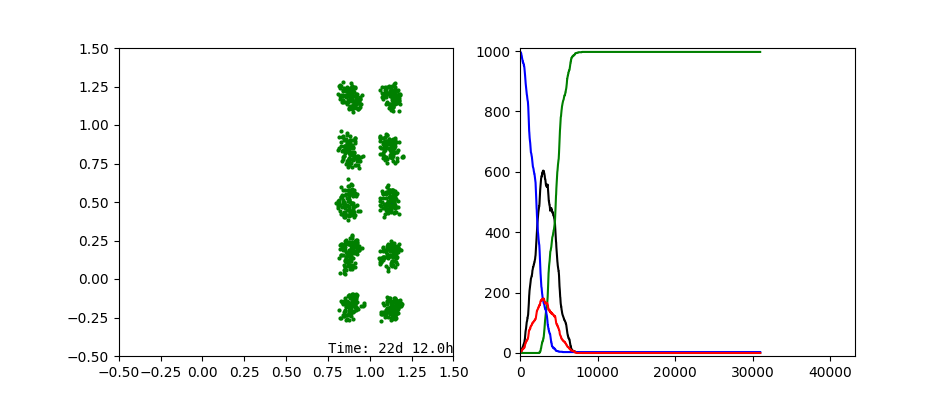

In [42]:
pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1, repeat=False)
plt.show()

### Lockdown / práce z domu

Poslední úpravou naší simulace bude vynucení některých teček, aby zůstaly doma. Budeme uvažovat novou proměnnou, která určí kolik % lidí přestane chodit do práce a zůstane doma.

In [43]:
procento_lidi_pracujicich_z_domu = 0.5

<hr style="border:1px solid black"> </hr>

## Úkol 8: 
Upravte funkci **reset_simulace** tak, aby **procento_lidi_pracujicich_z_domu** % lidí měli jako své pracoviště nastaveno svůj domov.

<hr style="border:1px solid black"> </hr>

In [44]:
def reset_simulace():
    # původní kód
    pozice = np.random.rand(pocet_lidi,2)
    doba_od_nakazeni = np.zeros((pocet_lidi))
    stav = np.full(pocet_lidi,'S')
    stav[0:4] = 'I'
    domovy_lidi = domovy[np.random.randint(0, grid_domovu[0]*grid_domovu[1], pocet_lidi),:]
    prace_lidi = prace[np.random.randint(0, grid_praci[0]*grid_praci[1], pocet_lidi), :]
    #----------------------------------------------------------------------------------------
    # zde doplňte, nejprve vygenerujte vektor identifikátorů True/False jestli se to lidí týká
    kdo_pracuje_z_domu = np.random.rand(pocet_lidi) < procento_lidi_pracujicich_z_domu
    # pak těm kterých ano (True) nastave práci jako jejich domov
    prace_lidi[kdo_pracuje_z_domu,:] = domovy_lidi[kdo_pracuje_z_domu,:]
    #----------------------------------------------------------------------------------------
    return pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi

Vyzkoušíme, jak simulace vypadá nyní:

<IPython.core.display.Javascript object>


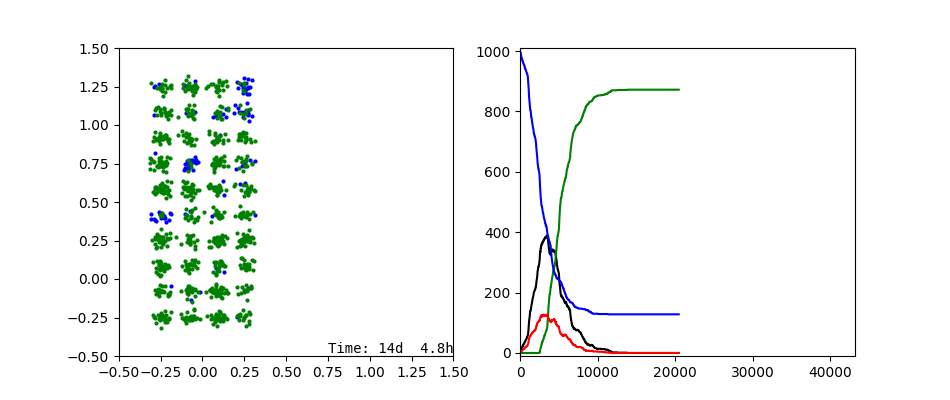

In [45]:
pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1,repeat=False)
plt.show()

### Konec

Tímto jsme dokončili naši zjednodušenou simulci šíření nákazy. To však neznamená, že si s ní nemůžete dále 'hrát'. Zkuste měnit jednotlivé parametry. Co podle vás nejvíce ovlivní rychlost šíření? 

<IPython.core.display.Javascript object>


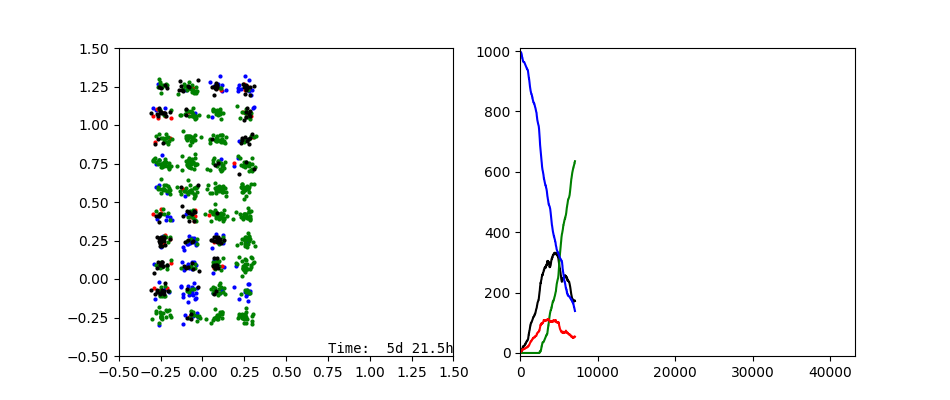

In [46]:
pocet_lidi=1000 #nezadavejte hodnoty vetsi nez 5000, simulace pak bude velmi pomala
delka_simulace=30*24*60 #30 dni * 24 hodin * 60 minut
vzdalenost_nakazy = 0.02 #vzdalenost na kterou se mužeme nakazit
pravdepodobnost_nakazy = 0.05 #pravděpodobnost, že se nakazíme
delka_nakazy = 7*24*15 #délka nákazy
procento_lidi_pracujicich_z_domu = 0.5
pravdepodobnost_zjisteni_a_karanteny = 0.75

pozice, stav, doba_od_nakazeni, domovy_lidi, prace_lidi = reset_simulace()
figure_animace, komponenty_grafu = nova_animace()
ani = FuncAnimation(figure_animace, update, frames=range(0,delka_simulace,cas_krok), interval=1,repeat=False)
plt.show()